Importing all require modules and packages

In [54]:
# Importing all modelues and packages required
import sqlite3 as sql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import time
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline,make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,StackingClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

# Tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [55]:
sns.set()
plt.rc('font', size=15)

Retrieving the dataset

In [56]:
#import opendatasets as od
#od.download("https` ://www.kaggle.com/competitions/titanic/data")

In [57]:
training = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

# to indicate whether the 
training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test],ignore_index=True)

%matplotlib inline
all_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

# 1. Data Exploration

Data attributes
* `Survived` : Whether the passenger survived the shipwreck
* `Pclass` : A proxy for socio-economic status (SES) of the passenger - 1 = Upper, 2 = Middle, 3 = Lower
* `Sex` : Sex of the passenger
* `Age` : Age of the passenger. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
* `Sibsp` : Number of siblings/spouses the passenger has aboard the ship
* `Parch` : Number of parents / children the passenger has aboard the ship
* `Ticket` : Ticket number
* `Fare` : Passenger fare paid for the ticket
* `Cabin` : Cabin number of the passenger
* `Embarked` : Port of Embarkation	- C = Cherbourg, Q = Queenstown, S = Southampton


Taking a look at the training dataset

In [58]:
# quick look at the dataset
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [59]:
print("Dataset dimension: ",training.shape)

Dataset dimension:  (891, 13)


In [60]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


Null data are identified for `Age`, `Cabin` and `Embarked`

In [61]:
training.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
train_test       1
dtype: int64

Ticket for some passengers are the same and there are 248 unique pricing for total tickets


Splitting into numerical and categorical data


In [62]:
# PassengerId  will not be included since it is just an indexof the passenger
# "Survived" is the target variable
# "train_test" is to classify whether the data is from training or test dataset

num_df = training[["Age","SibSp","Parch","Fare"]] #5 
cat_df = training[["Name", "Pclass", "Sex","Ticket","Cabin","Embarked"]] #5

## 1a. Target variable

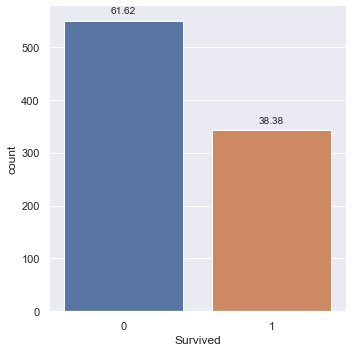

In [63]:
g = sns.catplot(x ="Survived", data = training , kind = "count",height = 5)

for ax in g.axes.ravel():
# obtaining the height of each bar graph
    ls = []
    for p in ax.patches:
        ls.append(p.get_height())

    # summing of all the total variables   
    total = 0
    for x in ls:
        total += x

    # Plotting the count plot
    for p in ax.patches:
        ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Survival rate of the passengers are low with 38% of passengers surviving. This might be considered imbalanced for classification and poised some difficulties during training later

## 1b. Numerical variables

In [64]:
num_df.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


Some passenger's `age` is missing from the dataset and will have to estimate their age based on Parch and SibSp

<AxesSubplot:>

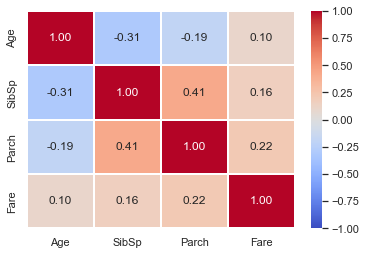

In [65]:
#f, axes = plt.subplots(1, 1, figsize=(12, 12))
sns.heatmap(num_df.corr(), vmin = -1, vmax = 1, linewidths = 1.5,
           annot = True, fmt = ".2f", annot_kws = {"size": 12}, cmap = 'coolwarm')

* `Age` have a relative negative correlation to `SibSp`, which might suggest that the older someone is, the seller number of siblings/spouse is onboard the ship.
* `SibSp` have a relative positive correlation to `Parch` which suggests that a portion of passengers are family (parents with children)

In [66]:
# Creating a plotting function for boxplot, histogram and violin plot for the variables
def plotting(data,a):
    f, axes = plt.subplots(3, figsize=(16, 12))
    sns.boxplot(data = data, x = data[a], orient = "h", color = 'r' , ax = axes[0])
    sns.histplot(data = data[a], color = 'g', ax = axes[1])
    sns.violinplot(data = data[a], orient = "h",ax = axes[2])

### i) Age variable

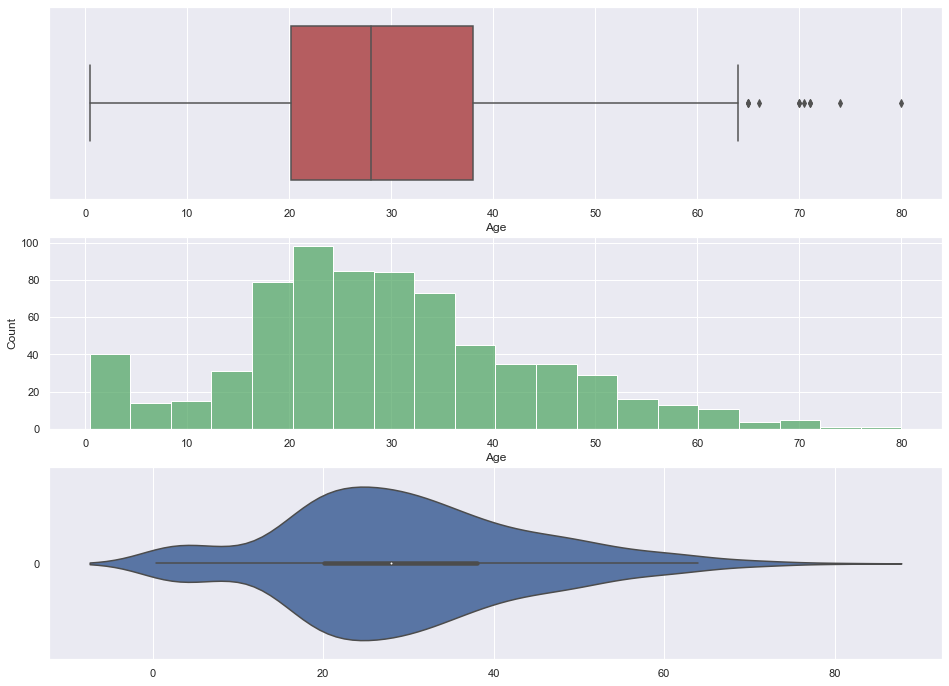

In [67]:
plotting(num_df,"Age")

In [68]:
# Taking a look at passenger details with age that is estimated
training[training.Age%2>1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S,1
203,204,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.2250,NaN,C,1
296,297,0,3,"Hanna, Mr. Mansour",male,23.5,0,0,2693,7.2292,NaN,C,1
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,C124,S,1


### ii) SibSp

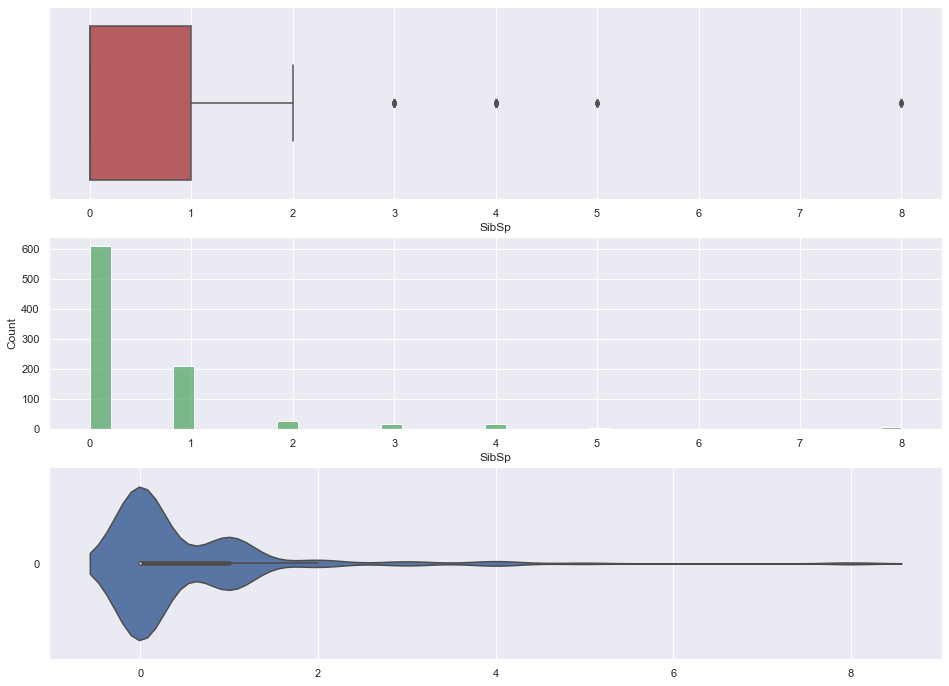

In [69]:
plotting(num_df,"SibSp")

### iii) Parch

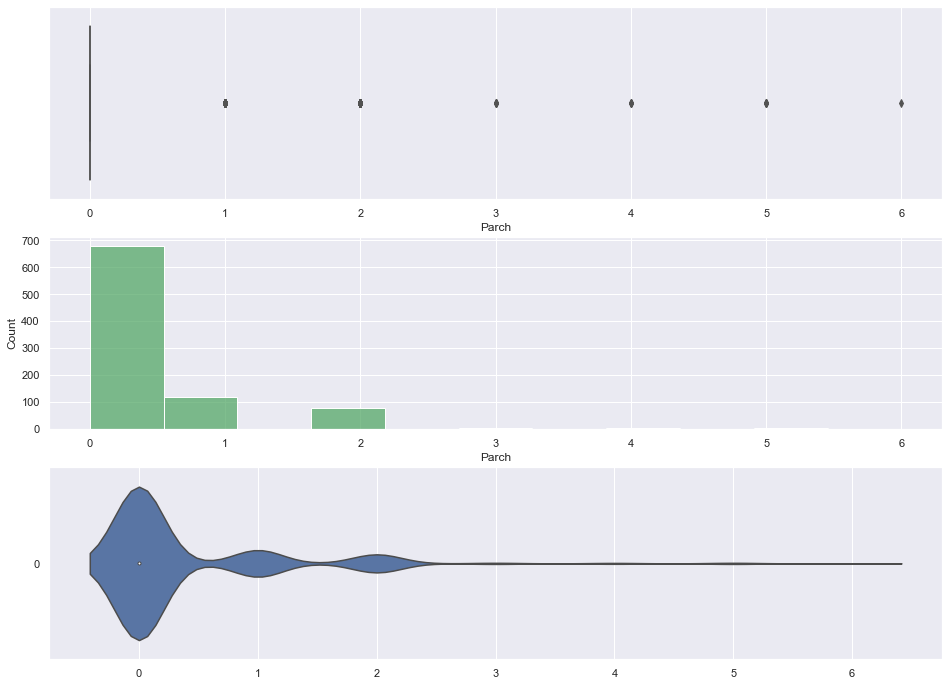

In [70]:
plotting(num_df,"Parch")

### iv) Fare

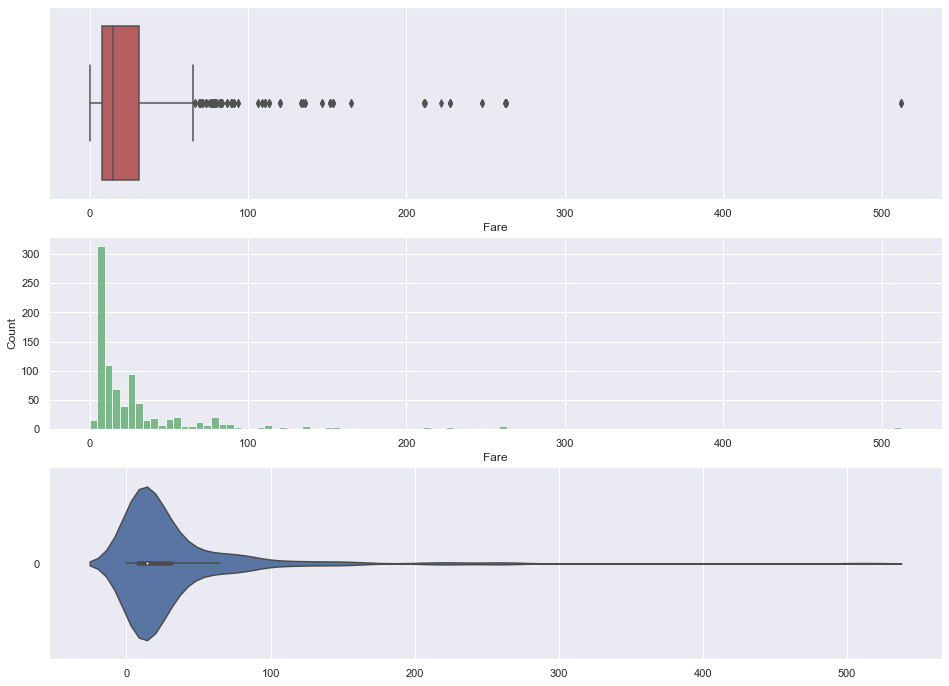

In [71]:
plotting(num_df,"Fare")

The distribution for fare is right skewed. It is weird that some passenger's fare is 0

## 1c. Relationship between Numerical variables with targer variables

In [72]:
print(pd.pivot_table(training, index = 'Survived', columns = 'Age', values = 'Ticket' ,aggfunc ='count'),"\n")
#print(pd.pivot_table(training, index = 'Survived', columns = '', values = 'Ticket' ,aggfunc ='count'),"\n")
print(pd.pivot_table(training, index = 'Survived', columns = 'Fare', values = 'Ticket' ,aggfunc ='count'),"\n")

Age       0.42   0.67   0.75   0.83   0.92   1.00   2.00   3.00   4.00   \
Survived                                                                  
0           NaN    NaN    NaN    NaN    NaN    2.0    7.0    1.0    3.0   
1           1.0    1.0    2.0    2.0    1.0    5.0    3.0    5.0    7.0   

Age       5.00   ...  62.00  63.00  64.00  65.00  66.00  70.00  70.50  71.00  \
Survived         ...                                                           
0           NaN  ...    2.0    NaN    2.0    3.0    1.0    2.0    1.0    2.0   
1           4.0  ...    2.0    2.0    NaN    NaN    NaN    NaN    NaN    NaN   

Age       74.00  80.00  
Survived                
0           1.0    NaN  
1           NaN    1.0  

[2 rows x 88 columns] 

Fare      0.0000    4.0125    5.0000    6.2375    6.4375    6.4500    \
Survived                                                               
0             14.0       1.0       1.0       1.0       1.0       1.0   
1              1.0       NaN       Na

## 1d. Categorical variables

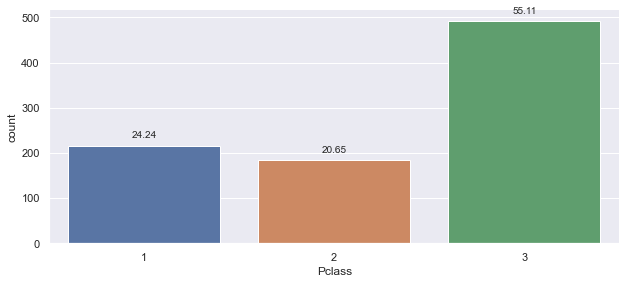

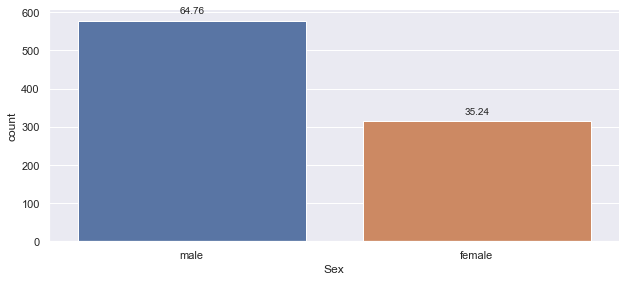

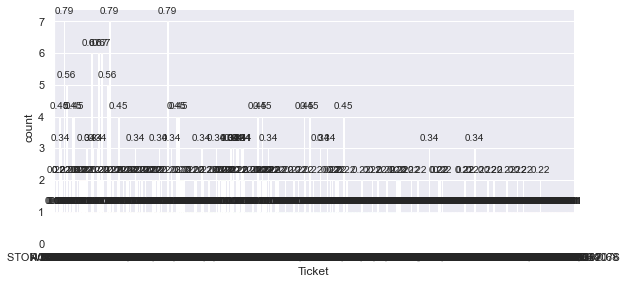

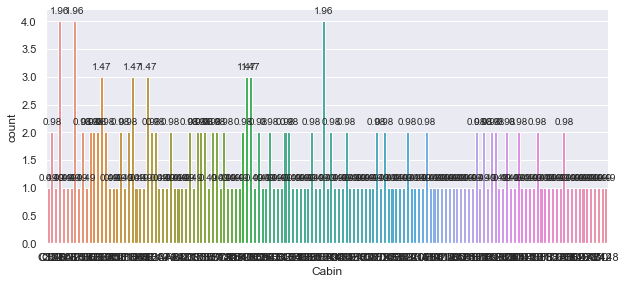

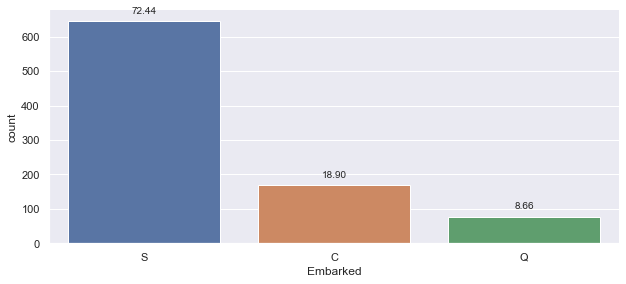

In [73]:
for var in cat_df:
    # Skipping the predictor variable Name
    if var =="Name":
        continue
    else:
        g = sns.catplot(x = var, data = cat_df , kind = "count",height = 4,aspect = 2.2)
        for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

#### i) Cabin Variable

In [74]:
# Taking a closer looking at the unique cabin number of each passenger
cat_df["Cabin"].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [75]:
#training.sort_values(by="Cabin").head(20)

#### ii) Name

In [76]:
training.sort_values(by='Name')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
845,846,0,3,"Abbing, Mr. Anthony",male,42.0,0,0,C.A. 5547,7.5500,NaN,S,1
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.0,1,1,C.A. 2673,20.2500,NaN,S,1
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,NaN,S,1
308,309,0,2,"Abelson, Mr. Samuel",male,30.0,1,0,P/PP 3381,24.0000,NaN,C,1
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,NaN,S,1
282,283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,1
361,362,0,2,"del Carlo, Mr. Sebastiano",male,29.0,1,0,SC/PARIS 2167,27.7208,NaN,C,1
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5000,NaN,S,1


## 1d. Relationship between categorical variables and target variable "Survived"

In [77]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'),"\n")
print(pd.pivot_table(training, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'),"\n")
print(pd.pivot_table(training, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'),"\n")

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119 

Sex       female  male
Survived              
0             81   468
1            233   109 

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217 



### i) Pclass vs Survived


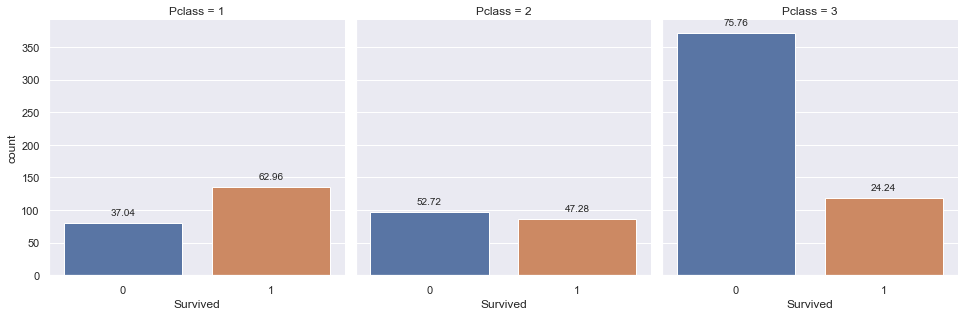

In [78]:
#plt.rc('font', size=12)
g=sns.catplot(data = training, x = 'Survived', col = 'Pclass', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

For Pclass, it seems that the higher SES the passengers are, the greater chance of survival.

### ii) Sex vs Survived

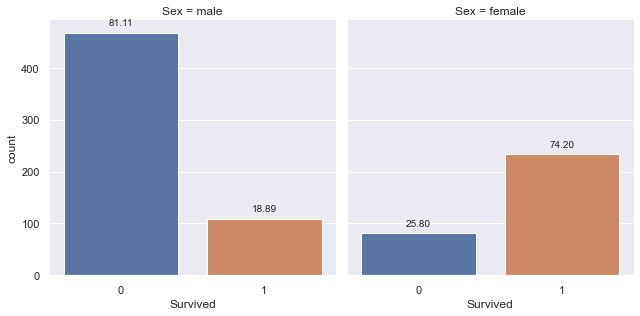

In [79]:
#plt.rc('font', size=12)
g=sns.catplot(data = training, x = 'Survived', col = 'Sex', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

A higher proportion of Female survived the shipwreck

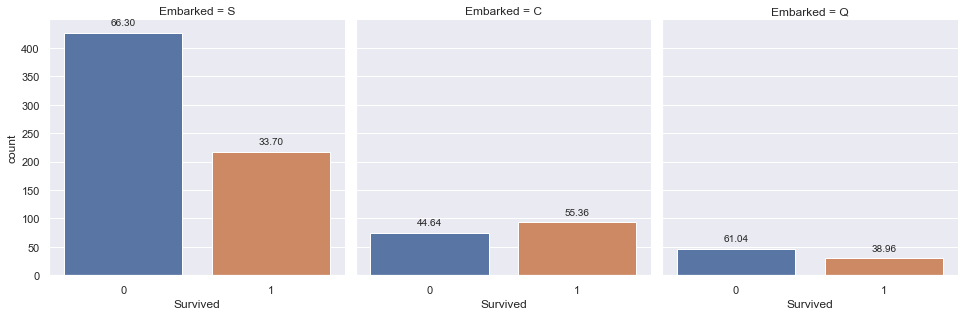

In [80]:
#plt.rc('font', size=12)
g=sns.catplot(data = training, x = 'Survived', col = 'Embarked', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# 2. Feature Engineering

## 2a. Does a person's title relate to survival rate?

In [81]:
# creating a list based on the names of the passenger without their names in parathesis
names = [name.split("(")[0] for name in list(training.Name)]

# Create a new column based on their title
training["Title"] = re.findall(r"(\w+)\.",str(names))

In [82]:
# taking a look at the different titles
training.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [83]:
# Creating a new column based on the title of the passenger if he/she of a nobility or special position in society
training["Special_title"] = training.Title.apply(lambda x: 1 if x in ("Don","Dr","Major","Lady","Sir","Col","Capt","Countess","Jonkheer") else 0)

Special_title    0  1
Survived             
0              540  9
1              334  8 



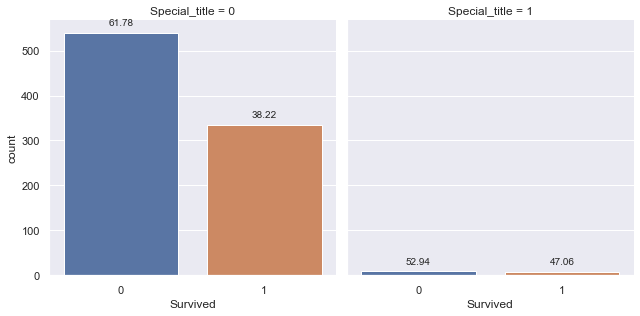

In [84]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'Special_title', values = 'Ticket' ,aggfunc ='count'),"\n")
g=sns.catplot(data = training, x = 'Survived', col = 'Special_title', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

It seems that passenger of a special title has a higher chances of survival.

## 2b) Does different ticket type relate to survival rate?

In [85]:
#understand ticket values better 
#numeric vs non numeric 
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['text_ticket'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','') if len(x.split(' ')[:-1]) >0 else 0)

numeric_ticket    0    1
Survived                
0               142  407
1                88  254 



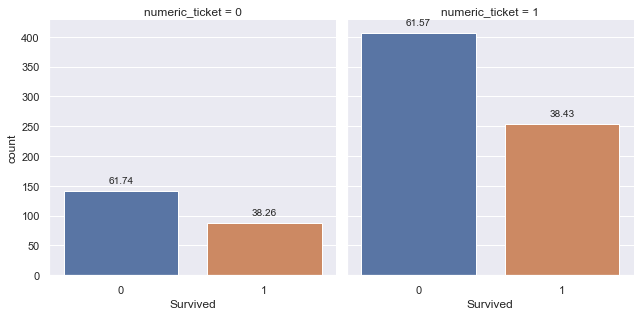

In [86]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'numeric_ticket', values = 'Ticket' ,aggfunc ='count'),"\n")
g=sns.catplot(data = training, x = 'Survived', col = 'numeric_ticket', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

It seems that ticket variation does not affect survival rate of passenger

## 2c) Does different types of traveller affect surivival rate?

`Travel_cat`: The category of each passenger based on their travel size
* 1: Individual traveller
* 2: Travelling as a couple/sibling
* 3: Travelling as a family

In [87]:
# Creating a column to determine the travel size of each passenger 
training["travel_size"] = training.SibSp + training.Parch + 1

# Creating a category of each passenger based on travel size
training["travel_cat"] =  training.travel_size.apply(lambda x: 3 if x >2 else (2 if x == 2 else 1))


travel_cat    1   2    3
Survived                
0           374  72  103
1           163  89   90 



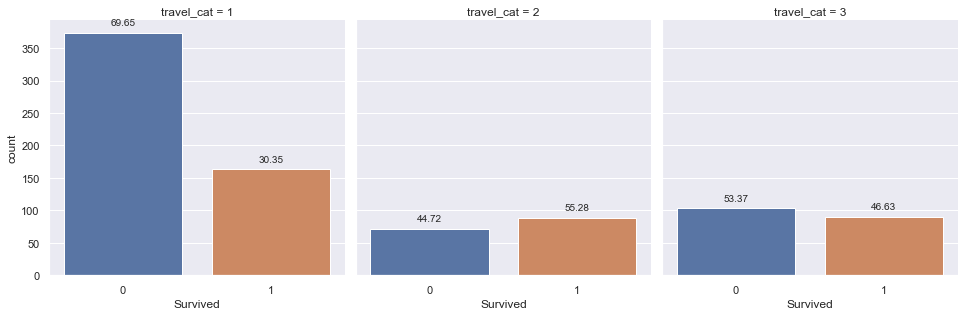

In [88]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'travel_cat', values = 'Ticket' ,aggfunc ='count'),"\n")
g=sns.catplot(data = training, x = 'Survived', col = 'travel_cat', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Based on travel_cat, it seems that passengers that are travelling more than 1 pax has a higher chance of survival

## 2d) Does different age group of traveller affect surivival rate?

Since a portion of passenger age is missing from the dataset, we can create a age group to differentiate each passenger

In [89]:
age_group=[]
for row,column in training.iterrows():
    # For passenger with age missing
    if np.isnan(training.Age[row]) :
        # To identify children
        if ((training.SibSp[row] > 2) or ((training.SibSp[row] ==1)&(training.Parch[row] ==1))):
            age_group.append('Child')
        else:
            age_group.append('Adult')
    else:
        if training.Age[row] <= 14:
            age_group.append('Child')
        else:
            age_group.append('Adult')
training['age_group'] = age_group



age_group  Adult  Child
Survived               
0            506     43
1            294     48 



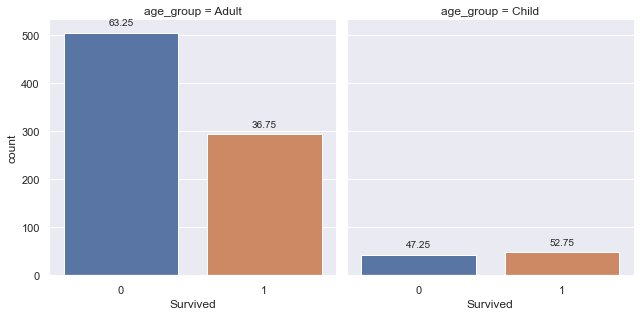

In [90]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(training, index = 'Survived', columns = 'age_group', values = 'Ticket' ,aggfunc ='count'),"\n")
g=sns.catplot(data = training, x = 'Survived', col = 'age_group', kind = 'count',  height = 4.5)
for ax in g.axes.ravel():
        # obtaining the height of each bar graph
            ls = []
            for p in ax.patches:
                ls.append(p.get_height())
        
             # summing of all the total variables   
            total = 0
            for x in ls:
                total += x
        
            # Plotting the count plot
            for p in ax.patches:
                ax.annotate(format(p.get_height()/total*100, '.2f'), (p.get_x() + p.get_width() / 2.,
                p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Children have a higher survival rate as compared to adults

# 3. Data Preprocessing

In [91]:
# creating a list based on the names of the passenger without their names in parathesis
name_list = [name.split("(")[0] for name in list(all_data.Name)]

# Create a new column based on their title
all_data["Title"] = re.findall(r"(\w+)\.",str(name_list))

# Creating a new column based on the title of the passenger if he/she of a nobility or special position in society
all_data["Special_title"] = all_data.Title.apply(lambda x: 1 if x in ("Don","Dr","Major","Lady","Sir","Col","Capt","Countess","Jonkheer") else 0)

# Creating a column to determine the travel size of each passenger 
all_data["travel_size"] = all_data.SibSp + all_data.Parch + 1

# Creating a category of each passenger based on travel size
all_data["travel_cat"] =  all_data.travel_size.apply(lambda x: 3 if x >2 else (2 if x == 2 else 1))

age_group=[]
for row,column in all_data.iterrows():
    # For passenger with age missing
    if np.isnan(all_data.Age[row]):
        # To identify children
        if (all_data.SibSp[row] > 2) | ((all_data.SibSp[row] ==1)&(all_data.Parch[row] ==1)):
            age_group.append('Child')
        else:
            age_group.append('Adult')
    else:
        if all_data.Age[row] <= 14:
            age_group.append('Child')
        else:
            age_group.append('Adult')
all_data['age_group'] = age_group

# Fill Fare that is NA 
all_data.Fare = all_data.Fare.fillna(all_data.groupby('Pclass').Fare.median()[3])

#Create a copy of the dataframe
df = all_data.copy()

#drop null 'embarked' rows. Only 2 instances of this in training and 0 in test 
df.dropna(subset=['Embarked'],inplace = True)

#drop the following columns: PassengerID, Ticket, Cabin, Title, Age
df.drop(columns=['PassengerId','Name','Age','Ticket','Cabin','Title'],inplace=True)

# Replace Fare that are 0 with median Fare price
for row, column in df.iterrows():
    if (df.Fare[row] == 0) & (df.Pclass[row] == 1):
        df.Fare[row] = df.groupby('Pclass').Fare.median()[1]
    elif (df.Fare[row] == 0) & (df.Pclass[row] == 2):
        df.Fare[row] = df.groupby('Pclass').Fare.median()[2]
    elif (df.Fare[row] == 0) & (df.Pclass[row] == 3):
        df.Fare[row] = df.groupby('Pclass').Fare.median()[3]

# Convert Pclass, travel_cat to str
df.Pclass = df.Pclass.astype(str)
df.travel_cat = df.travel_cat.astype(str)
df.Special_title = df.Special_title.astype(bool) 

C:\Users\kelvin.tanwm\AppData\Local\Temp\ipykernel_31024\1081556623.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Fare[row] = df.groupby('Pclass').Fare.median()[3]
C:\Users\kelvin.tanwm\AppData\Local\Temp\ipykernel_31024\1081556623.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Fare[row] = df.groupby('Pclass').Fare.median()[1]
C:\Users\kelvin.tanwm\AppData\Local\Temp\ipykernel_31024\1081556623.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [111]:
# Creating train and test set
X_train = df[df.train_test == 1].drop(['train_test','Survived'],axis = 1)
y_train = df[df.train_test == 1].Survived
X_test = df[df.train_test == 0].drop(['train_test','Survived'],axis = 1)

In [112]:
# Scaling and encoding the data
ct = ColumnTransformer([ 
        #('Scaled Age', StandardScaler(), ['Age']) # -1 to 1 
        ('Numerical Variables',MinMaxScaler(), ['SibSp','Parch','Fare','travel_size']) 
        ,('Catergorical Variables', OneHotEncoder(), ['Pclass','Sex','Embarked','travel_cat','age_group'])
],remainder='passthrough') # Special_title

In [113]:
X_train = ct.fit_transform(X_train)
X_test = ct.fit_transform(X_test)
# Smoting the imbalanced dataset
# X, y =  SMOTE().fit_resample(X_transform,y_raw)

In [115]:

# Classifier models 
lr = LogisticRegression(max_iter = 2000) #Using logistic regression as a baseline
rf = RandomForestClassifier(n_estimators = 200,random_state = 41 ,n_jobs=-1)
lgbm = LGBMClassifier(n_jobs = -1)
xgbc = xgb.XGBClassifier()
et = ExtraTreesClassifier()
#stacking_clf = StackingClassifier(estimators = [('rf',rf),('xgbc',xgbc),('lgbm',lgbm),('et',et)]) 

models = [['LogisticRegression',lr,{'max_iter' : [2000],'penalty' : ['l1', 'l2'],'C' : np.logspace(-4, 4, 20),'solver' : ['liblinear']}]
            ,['RandomForestClassifier',rf,{'n_estimators': np.arange(50,300,25),'criterion':['gini','entropy'],'max_depth': np.arange(10,30,5), 'min_samples_split': [2,3],'min_samples_leaf': [1,2,3],'max_features': ['log2','sqrt'], 'bootstrap':[True], 'random_state': [41],'n_jobs': [-1]}]
            ,['XGBClassifier', xgbc,{'n_estimators': np.arange(200,550,50),'colsample_bytree': [0.75,0.8,0.85],'max_depth': [None],'reg_alpha': [1],'reg_lambda': [2, 5, 10],'subsample': [0.55, 0.6, .65],'gamma':[.5,1,2],'min_child_weight':[0.01],'sampling_method': ['uniform']}]
            ,['LGBMClassifier',lgbm,{'n_jobs': [-1],'reg_alpha': np.arange(0.0,1,0.1),'reg_lambda': np.arange(0.1,1,0.1),'max_depth': [-1]}]
            ,['ExtraTreesClassifier',et,{'n_estimators': np.arange(80,120,10), 'bootstrap': (True, False), 'n_jobs': (-1,), 'max_features': ("sqrt","log2"), 'min_samples_leaf': (1,2, 3)}]
            #,['StackingClassifier',stacking_clf]
            ]

# Create a function to bulk train all models and see their
def bulk_train(variables, target):
    for model in models:
        cv = cross_val_score(model[1],variables,target,cv=5)
        print(f'{model[0]}\n',cv)
        print('Mean CV score: ',cv.mean())
        print('='*50)

# Create a function to show the performance of all models
def show_performance(X_train = None, X_test = None, y_train = None,y_test = None,models = None,trained = None):
    for model in models:
        if trained == False:
            model[1].fit(X_train,y_train)
        predict = model[1].predict(X_test)
        # Plotting the confusion matrix
        cm=confusion_matrix(y_test, predict)
        conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],
                                         index=['Actual:0','Actual:1'])

        plt.figure(figsize = (8,5))
        sns.heatmap(conf_matrix, annot=True,fmt='d')
        plt.title(f"Confusion Matrix for {model[0]}")
        plt.yticks(rotation=360)
        plt.show()
        
        print(f"Accuracy Score for {model[0]} :",accuracy_score(y_test,predict))
        print(f"F1 Score for {model[0]} :", f1_score(y_test,predict))
        print("-"*100)
        print(f"\nClassification Report for {model[0]} :\n\n",classification_report(y_test, predict))
        print("="*100)

# Create a tuning function to train all models based on CV score
def tuning(X_train = None, y_train = None):
    start_time = time.time()
    # Create a tracker to find the best parameter
    def clf_performance(classifier, model_name):
        print(model_name)
        print('Best Score: ' + str(classifier.best_score_))
        print('Best Parameters: ' + str(classifier.best_params_))
        print('='*100)

    result =[]
    for model in models:
        clf = HalvingGridSearchCV(model[1], param_grid = model[2], scoring = 'f1',cv = 5, n_jobs = -1, random_state = 41) # n_jobs = -1 using all processors
        best_clf = clf.fit(X_train,y_train)
        result.append([model[0],best_clf])
        clf_performance(best_clf,f'{model[0]}')
        print('Time taken: {:.2f} seconds'.format(time.time() - start_time))
    #return result

In [121]:
bulk_train(variables = X_train, target = y_train)

LogisticRegression
 [0.78651685 0.80337079 0.79213483 0.78651685 0.82485876]
Mean CV score:  0.7986796165809688
RandomForestClassifier
 [0.76966292 0.76966292 0.8258427  0.80898876 0.82485876]
Mean CV score:  0.7998032120865867
XGBClassifier
 [0.78089888 0.79775281 0.85393258 0.83146067 0.86440678]
Mean CV score:  0.8256903446962485
LGBMClassifier
 [0.79775281 0.78651685 0.86516854 0.81460674 0.85310734]
Mean CV score:  0.8234304576905986
ExtraTreesClassifier
 [0.78089888 0.76404494 0.80898876 0.80898876 0.81920904]
Mean CV score:  0.7964260775725259


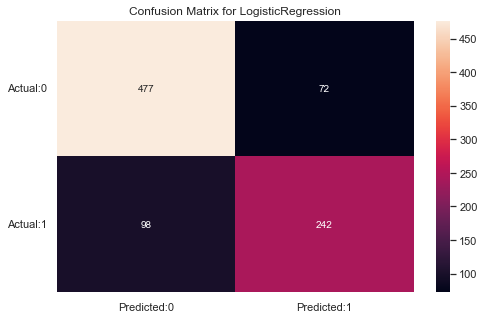

Accuracy Score for LogisticRegression : 0.8087739032620922
F1 Score for LogisticRegression : 0.7400611620795107
----------------------------------------------------------------------------------------------------

Classification Report for LogisticRegression :

               precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       549
         1.0       0.77      0.71      0.74       340

    accuracy                           0.81       889
   macro avg       0.80      0.79      0.79       889
weighted avg       0.81      0.81      0.81       889



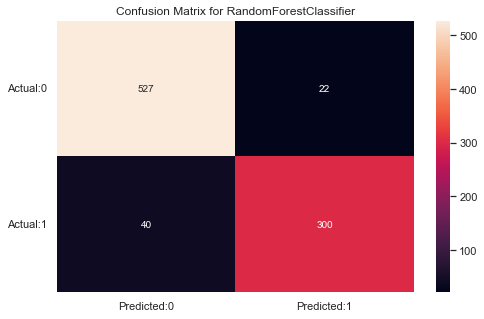

Accuracy Score for RandomForestClassifier : 0.9302587176602924
F1 Score for RandomForestClassifier : 0.9063444108761329
----------------------------------------------------------------------------------------------------

Classification Report for RandomForestClassifier :

               precision    recall  f1-score   support

         0.0       0.93      0.96      0.94       549
         1.0       0.93      0.88      0.91       340

    accuracy                           0.93       889
   macro avg       0.93      0.92      0.93       889
weighted avg       0.93      0.93      0.93       889



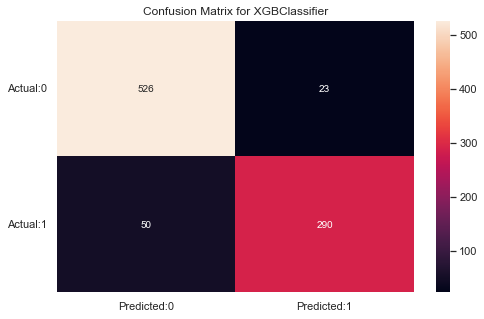

Accuracy Score for XGBClassifier : 0.9178852643419573
F1 Score for XGBClassifier : 0.8882082695252681
----------------------------------------------------------------------------------------------------

Classification Report for XGBClassifier :

               precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       549
         1.0       0.93      0.85      0.89       340

    accuracy                           0.92       889
   macro avg       0.92      0.91      0.91       889
weighted avg       0.92      0.92      0.92       889



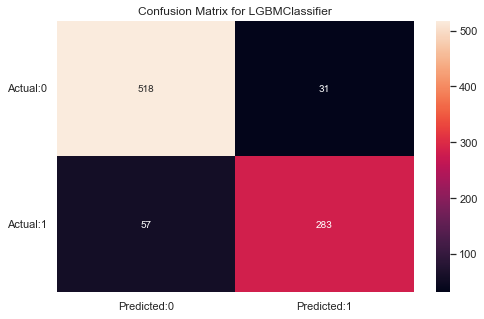

Accuracy Score for LGBMClassifier : 0.9010123734533183
F1 Score for LGBMClassifier : 0.8654434250764526
----------------------------------------------------------------------------------------------------

Classification Report for LGBMClassifier :

               precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       549
         1.0       0.90      0.83      0.87       340

    accuracy                           0.90       889
   macro avg       0.90      0.89      0.89       889
weighted avg       0.90      0.90      0.90       889



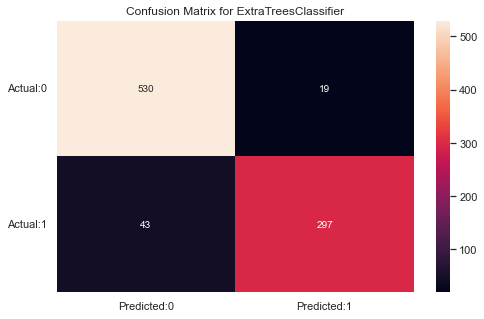

Accuracy Score for ExtraTreesClassifier : 0.9302587176602924
F1 Score for ExtraTreesClassifier : 0.9054878048780487
----------------------------------------------------------------------------------------------------

Classification Report for ExtraTreesClassifier :

               precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       549
         1.0       0.94      0.87      0.91       340

    accuracy                           0.93       889
   macro avg       0.93      0.92      0.93       889
weighted avg       0.93      0.93      0.93       889



In [122]:
show_performance(X_train = X_train, X_test= X_train, y_train = y_train, y_test= y_train, models = models, trained = False)

Random Forest Classifier seems to peform the best with the highest F1 score

# Tuning the model hyperparameters

In [107]:
tuning(X_train= X_train, y_train= y_train)

LogisticRegression
Best Score: 0.7322410854997351
Best Parameters: {'C': 11.288378916846883, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Time taken: 5.09 seconds
RandomForestClassifier
Best Score: 0.7478333508695062
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 275}
Time taken: 1105.97 seconds
XGBClassifier
Best Score: 0.7712805125800906
Best Parameters: {'colsample_bytree': 0.85, 'gamma': 0.5, 'max_depth': None, 'min_child_weight': 0.01, 'n_estimators': 250, 'reg_alpha': 1, 'reg_lambda': 2, 'sampling_method': 'uniform', 'subsample': 0.65}
Time taken: 1498.51 seconds
LGBMClassifier
Best Score: 0.8127641873396986
Best Parameters: {'max_depth': -1, 'n_jobs': -1, 'reg_alpha': 0.2, 'reg_lambda': 0.6}
Time taken: 1501.99 seconds
ExtraTreesClassifier
Best Score: 0.7427134747098589
Best Parameters: {'bootstrap': True, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 

In [ ]:
# # Retrieving the feature importances for Random Forest Classifier 
# best_rf = a[1][1].best_estimator_.fit(X_train,y_train)
# feat_importances = pd.Series(best_rf.feature_importances_, index = get_feature_names(ct))
# feat_importances.nlargest(20).plot(kind='barh')

# Submission of the final prediction

In [117]:
rf.fit(X_train, y_train)
y_hat_rf = rf.predict(X_test).astype(int)

final_data = {'PassengerId': test.PassengerId, 'Survived': y_hat_rf}
submission = pd.DataFrame(data=final_data)


In [120]:
#prepare submission files 
submission.to_csv('submission_rf.csv', index =False)